In [2]:
import os
import urllib
import sys

import cv2
import numpy as np
import matplotlib.pyplot as plt

import skimage.io as io
from skimage.util import random_noise

from sklearn.model_selection import train_test_split

from torch.optim import lr_scheduler

import glob

In [3]:
train_list = glob.glob('../dataset/BSD300/images/train/*')
test_list = glob.glob('../dataset/BUSI/malignant/*).png')

In [4]:
ims = []

for image in train_list:
  im =  io.imread(image, as_gray = True)
  image = cv2.resize(im, (256, 256))
  
  img90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE) # 시계방향으로 90도 회전
  img180 = cv2.rotate(image, cv2.ROTATE_180) # 180도 회전
  img270 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE) # 반시계방향으로 90도 회전
  
  
  ims.extend([image, img90, img180, img270])

ims = np.array(ims)

In [5]:
noised_dataset = []
for img in ims:
  noisy = random_noise(img, mode = 'speckle', var=0.003)
  noised_dataset.append(noisy)

noised_dataset = np.array(noised_dataset)
noised_dataset.shape

(800, 256, 256)

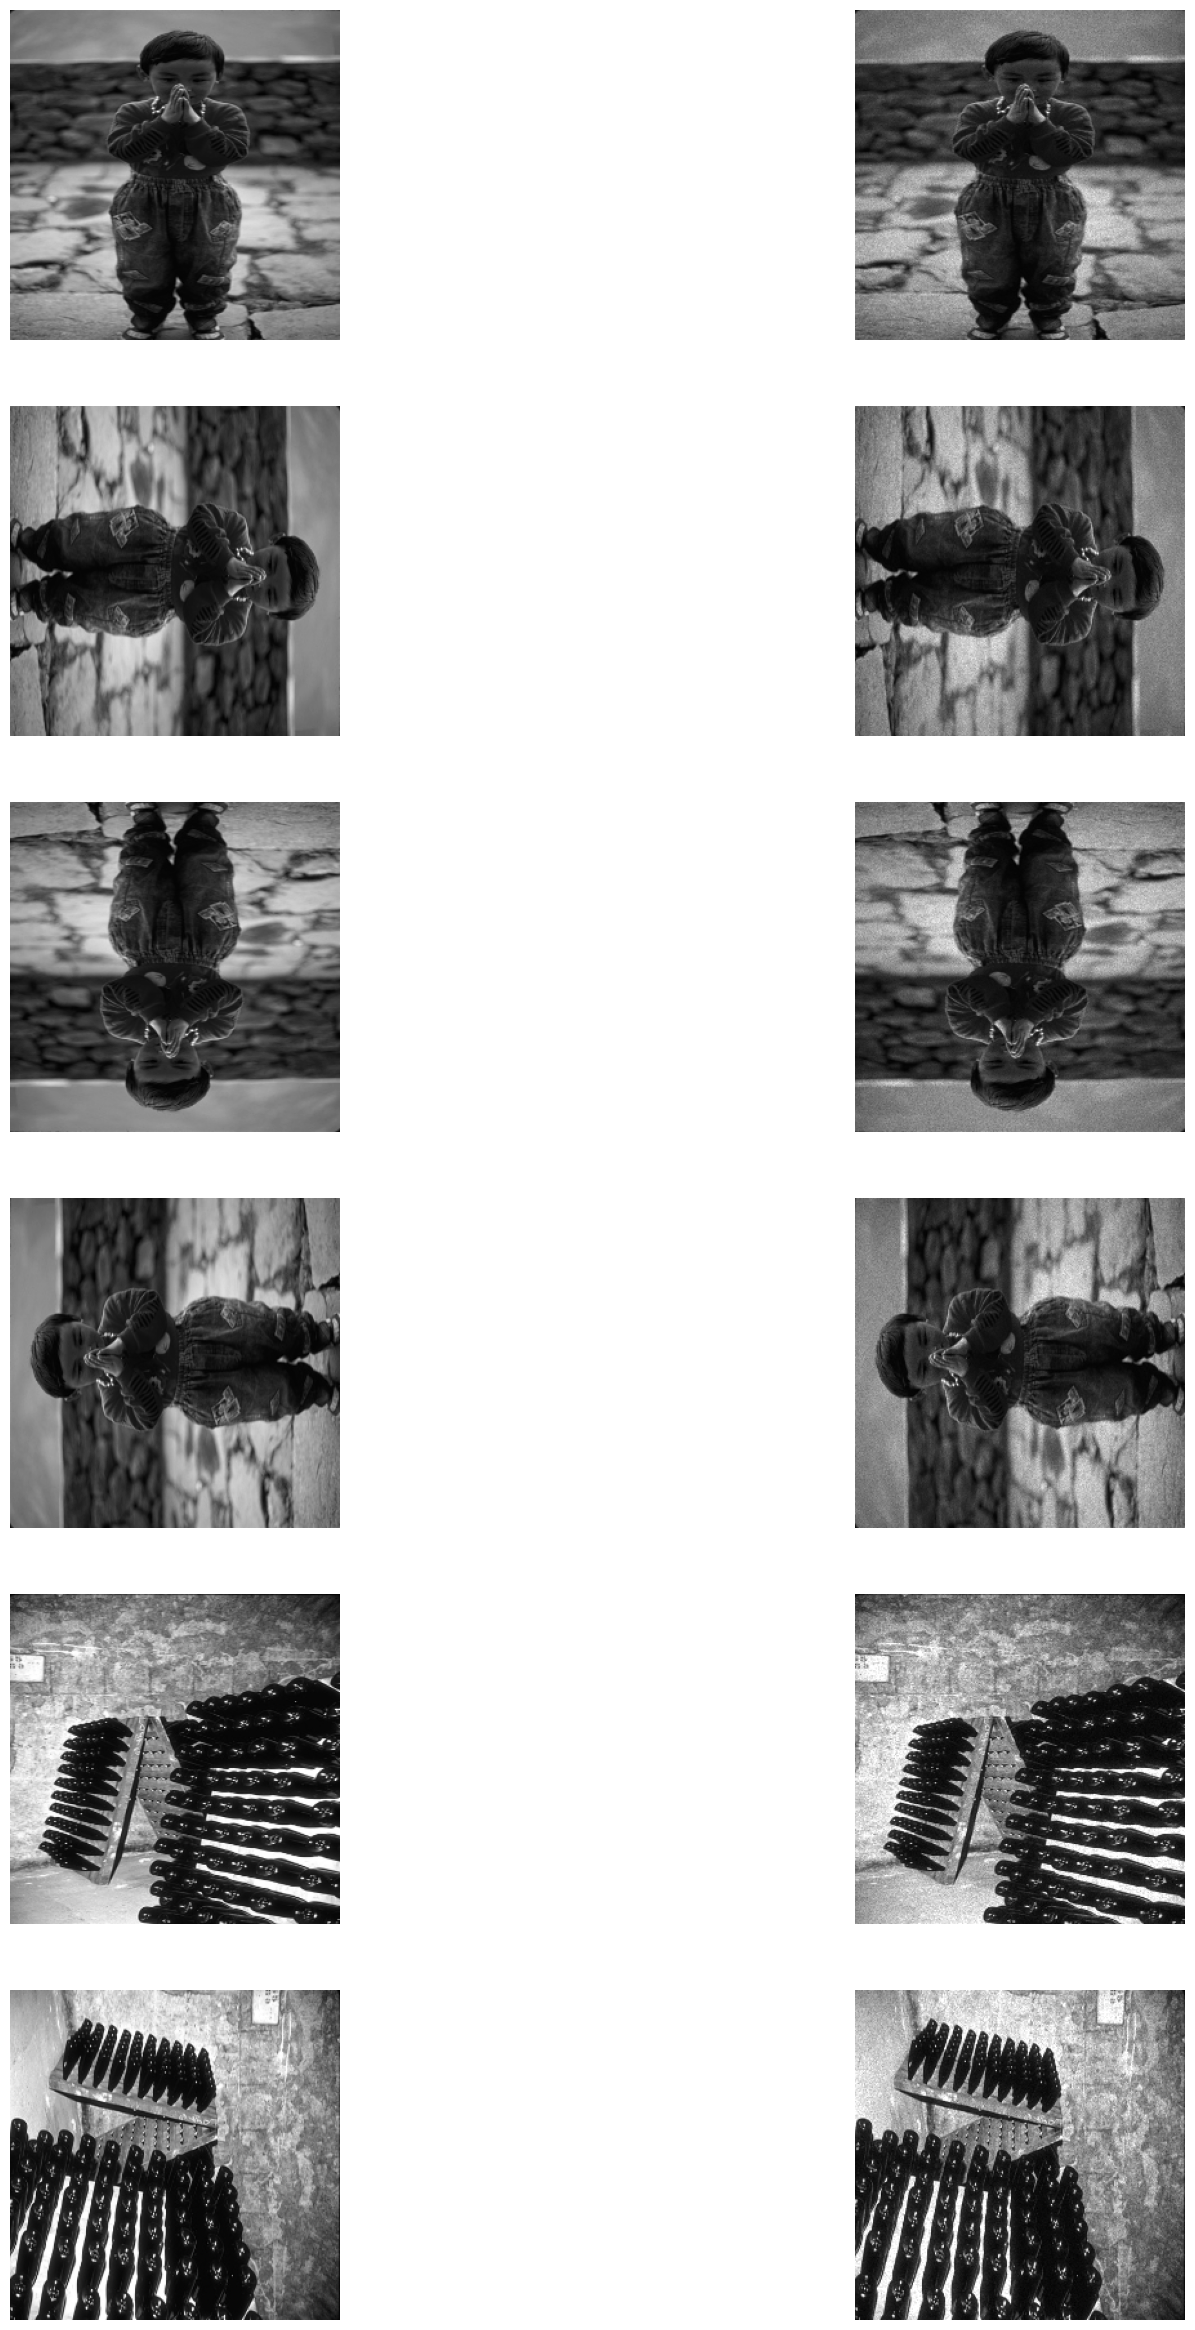

In [6]:
N_show = 6

plt.figure(figsize=(10*2, 5*N_show))
for i in range(N_show):
  plt.subplot(N_show, 2, 2*i+1)
  plt.imshow(ims[i], cmap='gray')
  plt.axis('off')

  plt.subplot(N_show, 2, 2*i+2)
  plt.imshow(noised_dataset[i], cmap='gray')
  plt.axis('off')
plt.show()

In [7]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision.models as models

class Basic(nn.Module): 
    def __init__(self, in_ch, out_ch, g=16, channel_att=False, spatial_att=False):
        super(Basic, self).__init__()
        self.channel_att = channel_att
        self.spatial_att = spatial_att
        self.conv1 = nn.Sequential(   # (bs,in_ch,w,h) -> (bs,out_ch,w,h)
                nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, stride=1, padding=1),
                # nn.BatchNorm2d(out_ch),
                nn.ReLU(),
                nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, stride=1, padding=1),
                # nn.BatchNorm2d(out_ch),
                nn.ReLU(),
                nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, stride=1, padding=1),
                # nn.BatchNorm2d(out_ch),
                nn.ReLU()
            )

        if channel_att: # 提炼重组一下各个channel
            self.att_c = nn.Sequential(  # (bs,2*out_ch,w,h) -> (bs,out_ch,w,h)
                nn.Conv2d(2*out_ch, out_ch//g, 1, 1, 0),
                nn.ReLU(),
                nn.Conv2d(out_ch//g, out_ch, 1, 1, 0),
                nn.Sigmoid()
            )
        if spatial_att: # 提炼重组一下mapping(即在(w,h)维度)
            self.att_s = nn.Sequential( # (bs,2,w,h) -> (bs,1,w,h)
                nn.Conv2d(in_channels=2, out_channels=1, kernel_size=7, stride=1, padding=3),
                nn.Sigmoid()
            )

    def forward(self, data):
        """
        Forward function.
        :param data:
        :return: tensor
        """
        fm = self.conv1(data)   # (bs,out_ch,w,h)
        if self.channel_att: # 안씀
            # adaptive_avg_pool2d 将(w,h)大小变成任意大小，如下面变成了(1,1),则经过cat之后为 (bs,2*out_ch,1,1)
            fm_pool = torch.cat([F.adaptive_avg_pool2d(fm, (1, 1)), F.adaptive_max_pool2d(fm, (1, 1))], dim=1)
            att = self.att_c(fm_pool)   # (bs,out_ch,1,1)
            fm = fm * att               # (bs,out_ch,w,h)*(bs,out_ch,1,1) -> (bs,out_ch,w,h)
        if self.spatial_att: # 안씀
            # (bs,1,w,h) + (bs,1,w,h) -> (bs,2,w,h) channel上一个是mean，一个是max
            fm_pool = torch.cat([torch.mean(fm, dim=1, keepdim=True), torch.max(fm, dim=1, keepdim=True)[0]], dim=1)
            att = self.att_s(fm_pool) # (bs,1,w,h)
            fm = fm * att             # (bs,out_ch,w,h)*(bs,1,w,h) -> (bs,out_ch,w,h)
        return fm



class Unet(nn.Module):
    def __init__(self, color=False, blind_est=True, channel_att=False, spatial_att=False, core_bias=False):
        super(Unet, self).__init__()
        self.core_bias = core_bias
        self.color_channel = 3 if color else 1
        self.color = 3 if color else 1
        in_channel = self.color * (1 if blind_est else 2)
        out_channel = self.color
        if core_bias:
            out_channel += self.color

        self.conv1 = Basic(in_channel, 64, channel_att=False, spatial_att=False)
        self.conv2 = Basic(64, 128, channel_att=False, spatial_att=False)
        self.conv3 = Basic(128, 256, channel_att=False, spatial_att=False)
        self.conv4 = Basic(256, 256, channel_att=False, spatial_att=False)

        self.conv5 = Basic(256+256, 256, channel_att=channel_att, spatial_att=spatial_att)
        self.conv6 = Basic(256+128, 128, channel_att=channel_att, spatial_att=spatial_att)
        self.conv7 = Basic(128+64, 64, channel_att=channel_att, spatial_att=spatial_att)
        self.outc = Basic(64, out_channel, channel_att=channel_att, spatial_att=spatial_att)

        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight.data)
            nn.init.constant_(m.bias.data, 0.0)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight.data)
            nn.init.constant_(m.bias.data, 0.0)

    # 前向传播函数
    def forward(self, data_with_est, white_level=1.0):
        """
        forward and obtain pred image directly
        :param data_with_est: if blind estimation, it is same as data, Otherwise, it is the data concatenated with noise estimation map
        :return: pred_img_i and img_pred
        """
        conv1 = self.conv1(data_with_est)
        
        #print(conv1.shape)
        conv2 = self.conv2(F.avg_pool2d(conv1, kernel_size=2, stride=2))
        
        #print(conv2.shape)
        conv3 = self.conv3(F.avg_pool2d(conv2, kernel_size=2, stride=2))
        
        #print(conv3.shape)
        conv4 = self.conv4(F.avg_pool2d(conv3, kernel_size=2, stride=2))
        
        #print(conv4.shape)

        conv5 = self.conv5(torch.cat([conv3, F.interpolate(conv4, scale_factor=2, mode='bilinear')], dim=1))
        
        #print(conv5.shape)
        conv6 = self.conv6(torch.cat([conv2, F.interpolate(conv5, scale_factor=2, mode='bilinear')], dim=1))
        
        #print(conv6.shape)
        conv7 = self.conv7(torch.cat([conv1, F.interpolate(conv6, scale_factor=2, mode='bilinear')], dim=1))
        
        #print(conv7.shape)

        core = self.outc(conv7)   # (bs, ch, h, w)
        
        #print(f'core : {core.shape}')
        
        output = core[:,:self.color,:,:]
        bias = None if not self.core_bias else core[:,self.color:,:,:]
        if self.core_bias:
            if bias is None:
                raise ValueError('The bias should not be None.')
            output += bias
        
        return output

In [8]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPUs 2 and 3 to use


# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CPU
# device = "cpu"

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [9]:
model = Unet(color=False, blind_est=True, channel_att=False, spatial_att=False, core_bias=False).to(device)

# Parallel
#_model = Unet(color=False, blind_est=True, channel_att=False, spatial_att=False, core_bias=False).to(device)
#model = nn.DataParallel(_model).to(device)

In [10]:
model

Unet(
  (conv1): Basic(
    (conv1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
  )
  (conv2): Basic(
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
  )
  (conv3): Basic(
    (conv1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [11]:
ims.shape, noised_dataset.shape

((800, 256, 256), (800, 256, 256))

In [12]:
ims = ims[:, :, :, np.newaxis]
noised_dataset = noised_dataset[:, :, :, np.newaxis]

In [13]:
ims.shape, noised_dataset.shape

((800, 256, 256, 1), (800, 256, 256, 1))

In [14]:
N_ims , h, w, color = ims.shape
ims = ims[:N_ims].astype(np.float32).transpose(0, 3, 1, 2)
noised_dataset = noised_dataset[:N_ims].astype(np.float32).transpose(0, 3, 1, 2)

In [15]:
ims.shape, noised_dataset.shape

((800, 1, 256, 256), (800, 1, 256, 256))

In [16]:
# training hyperparameters
batch_size = 8
lr = 1e-3
epochs = 50
test_size = 0.05

In [17]:
# train test split

train_X, train_Y = noised_dataset, ims
print(train_X.shape)

train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=test_size, random_state=42)

print('Training X: ', train_X.shape, train_X.dtype, train_X.max(), train_X.min())
print('Training Y: ', train_Y.shape, train_Y.dtype, train_Y.max(), train_Y.min())
print('Testing X: ', test_X.shape, test_X.dtype, test_X.max(), test_X.min())
print('Testing Y: ', test_Y.shape, test_Y.dtype, test_Y.max(), test_Y.min())

(800, 1, 256, 256)
Training X:  (760, 1, 256, 256) float32 1.0 0.0005284283
Training Y:  (760, 1, 256, 256) float32 1.0 0.00053568085
Testing X:  (40, 1, 256, 256) float32 1.0 0.0052150586
Testing Y:  (40, 1, 256, 256) float32 1.0 0.0050675506


In [18]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):      #这个方法是必须要有的，用于按照索引读取每个元素的具体内容
        return self.X[index], self.Y[index]
    
    def __len__(self):                 #这个函数也必须要写，它返回的是数据集的长度，也就是多少张图片，要和loader的长度作区分
        return len(self.X)
        
train_set = MyDataset(train_X, train_Y)
test_set = MyDataset(test_X, test_Y)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [19]:
'''optimizer and loss function'''
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95) # learning rate decay(특정 epoch을 기준으로 감소)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # step_size == epoch
                                
#loss_func = LossBasic(gradient_L1 = True)
loss_func = nn.L1Loss()

In [20]:
train_losses = []
train_steps = 0

test_losses = []
lrs = []

best_loss = 1
patience_check = 0

In [21]:
for epoch in range(epochs):
    # train loss
    model.train()
    total_train_loss = total =0
    
    for inputs, target in train_loader:
        total += 1
        inputs, target = inputs.to(device), target.to(device)

        #print(inputs.shape)
        optimizer.zero_grad()

        outputs = model(inputs)
        
        #print(outputs.shape)
        #print(target.shape)

        loss = loss_func(outputs, target)

        loss.backward() 
        optimizer.step()
        
        total_train_loss += loss.item()
        train_losses.append(loss.item())
        train_steps += 1
    
    total_train_loss /= total
    
    # test
    model.eval()
    total_test_loss = total = 0
    for inputs, target in test_loader:
        total += 1
        inputs, target = inputs.to(device), target.to(device)

        outputs = model(inputs)
        
        test_loss = loss_func(outputs, target).item()
        total_test_loss += test_loss
    total_test_loss /= total
    test_losses.append(total_test_loss)

    if best_loss > total_test_loss:
        
        best_loss = total_test_loss
        torch.save(model.state_dict(), "./unet.pt")
        patience_check = 0  # 리셋

    else : 
        
        patience_check += 1

        if patience_check > 15 :

            print('early stopping!')
            break
    
    print(f"Epoch {epoch+1}; train loss {total_train_loss:.6f}; test loss {total_test_loss:.6f}")
    
        
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()

Epoch 1; train loss 0.193813; test loss 0.104969
Epoch 2; train loss 0.084891; test loss 0.066576
Epoch 3; train loss 0.062993; test loss 0.056419
Epoch 4; train loss 0.054682; test loss 0.053585
Epoch 5; train loss 0.047866; test loss 0.049731
Epoch 6; train loss 0.045704; test loss 0.042708
Epoch 7; train loss 0.041513; test loss 0.044678
Epoch 8; train loss 0.040478; test loss 0.042721
Epoch 9; train loss 0.037706; test loss 0.036544
Epoch 10; train loss 0.035818; test loss 0.033691
Epoch 11; train loss 0.035195; test loss 0.033531
Epoch 12; train loss 0.033778; test loss 0.031216
Epoch 13; train loss 0.031106; test loss 0.034388
Epoch 14; train loss 0.032180; test loss 0.029433
Epoch 15; train loss 0.031712; test loss 0.030248
Epoch 16; train loss 0.029807; test loss 0.028368
Epoch 17; train loss 0.030445; test loss 0.031158
Epoch 18; train loss 0.028975; test loss 0.028366
Epoch 19; train loss 0.029054; test loss 0.027530
Epoch 20; train loss 0.028866; test loss 0.031821
Epoch 21;

In [49]:
from collections import OrderedDict
new_state_dict = OrderedDict()

for k, v in torch.load("./unet_temp.pt").items():
    if 'module' in k:
        k = k.replace('module.', '')
    new_state_dict[k]=v
    
model = Unet(color=False, blind_est=True, channel_att=False, spatial_att=False, core_bias=False).to(device)
model.load_state_dict(new_state_dict)
model.eval()

Unet(
  (conv1): Basic(
    (conv1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
  )
  (conv2): Basic(
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
  )
  (conv3): Basic(
    (conv1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [10]:
model = Unet(color=False, blind_est=True, channel_att=False, spatial_att=False, core_bias=False).to(device)

model.load_state_dict(torch.load("./unet_F.pt"))
model.eval()

Unet(
  (conv1): Basic(
    (conv1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
  )
  (conv2): Basic(
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
  )
  (conv3): Basic(
    (conv1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [11]:
test_ims = []

for image in test_list:
  im = io.imread(image, as_gray = True)

  resized_image = cv2.resize(im, (256, 256))
  test_ims.append(resized_image) 


test_ims = np.array(test_ims)

In [12]:
a = torch.FloatTensor(test_ims[:4]).to(device)

In [13]:
model.eval() # 모델을 평가 모델로 전환
b = model(a.unsqueeze(1))

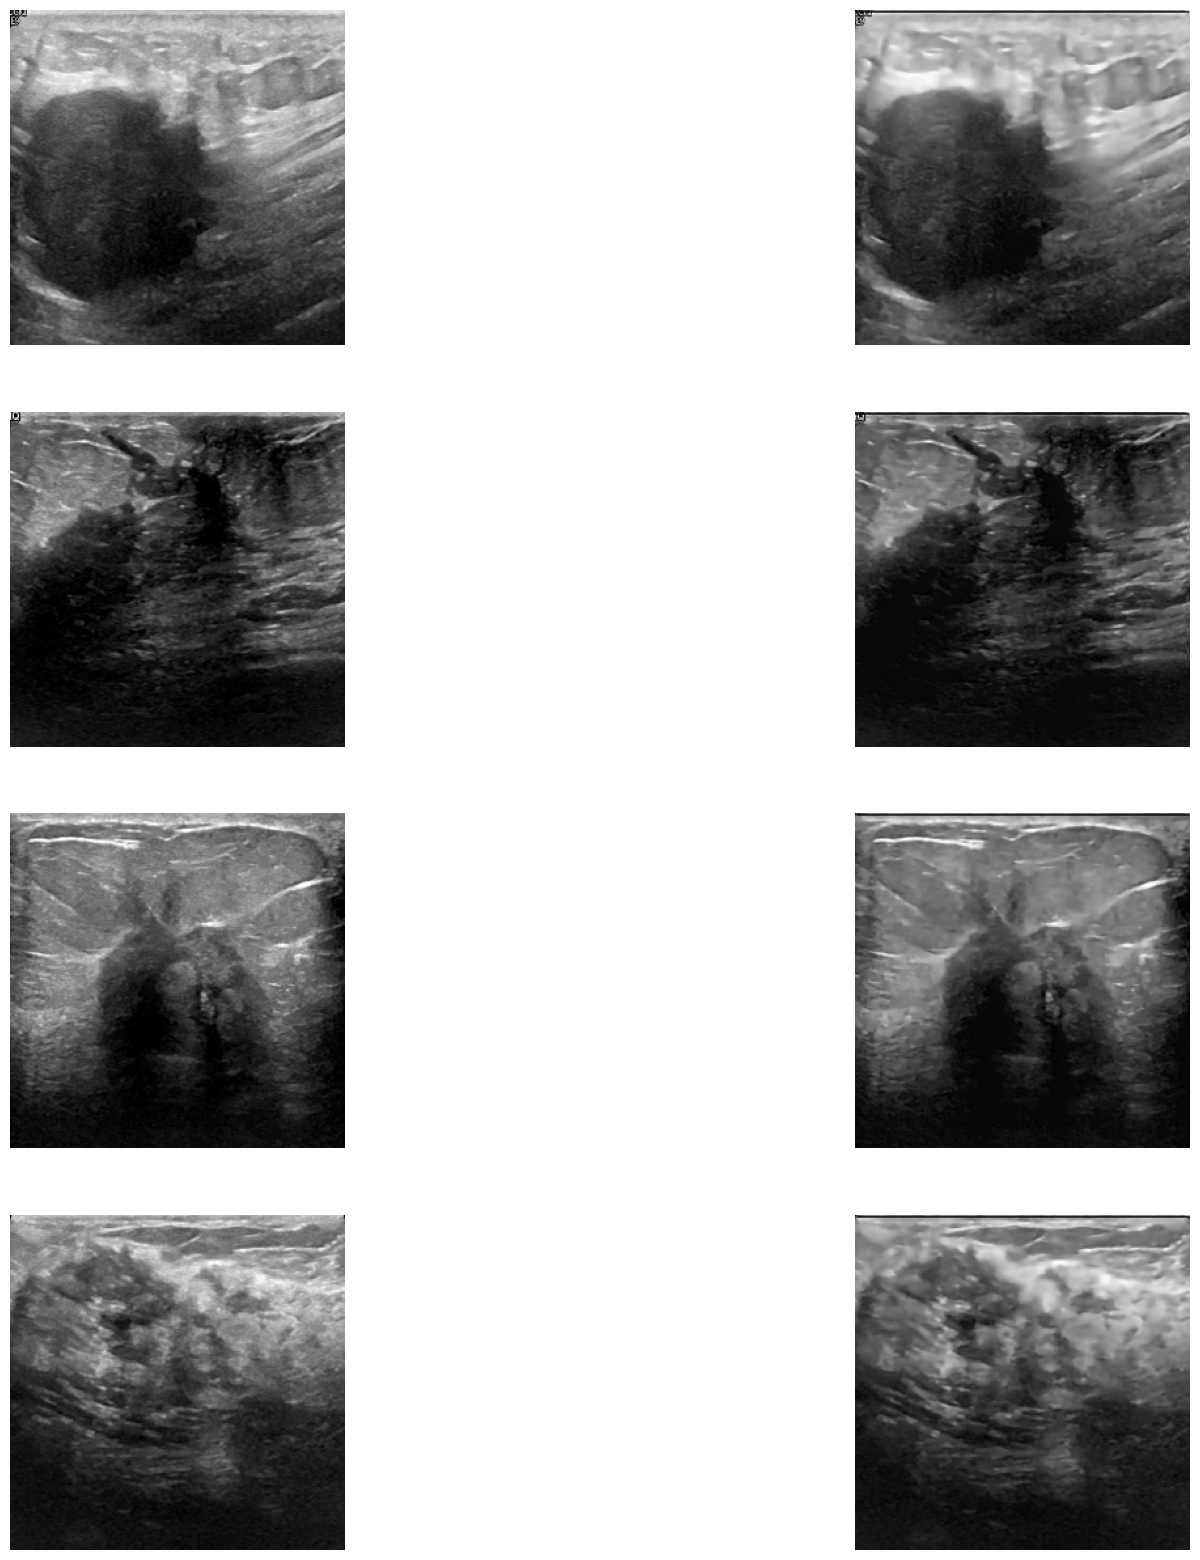

In [15]:
if __name__ == '__main__':
      N_show = 4

plt.figure(figsize=(10*2, 5*N_show))
for i in range(N_show):
  plt.subplot(N_show, 2, 2*i+1)
  plt.imshow(test_ims[i], cmap='gray')
  plt.axis('off')

  plt.subplot(N_show, 2, 2*i+2)
  plt.imshow(b[i].squeeze().cpu().detach().numpy(), cmap='gray')
  plt.axis('off')
plt.show()